# Get Data

In [ ]:
!wget https://data.mendeley.com/datasets/4drtyfjtfy/1/files/a03e6097-f7fb-4e1a-9c6a-8923c6a0d3e0/dataset2.zip

--2020-07-14 13:12:57--  https://data.mendeley.com/datasets/4drtyfjtfy/1/files/a03e6097-f7fb-4e1a-9c6a-8923c6a0d3e0/dataset2.zip
Resolving data.mendeley.com (data.mendeley.com)... 162.159.133.86, 162.159.130.86, 2606:4700:7::a29f:8556, ...
Connecting to data.mendeley.com (data.mendeley.com)|162.159.133.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/64a54851-f95a-439d-aff7-3334a684e532 [following]
--2020-07-14 13:12:57--  https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/64a54851-f95a-439d-aff7-3334a684e532
Resolving md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)... 52.218.58.0
Connecting to md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)|52.218.58.0|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95667925 (91M) [

In [ ]:
!unzip dataset2.zip

Archive:  dataset2.zip
   creating: dataset2/
  inflating: dataset2/cloudy1.jpg    
  inflating: dataset2/cloudy10.jpg   
  inflating: dataset2/cloudy100.jpg  
  inflating: dataset2/cloudy101.jpg  
  inflating: dataset2/cloudy102.jpg  
  inflating: dataset2/cloudy103.jpg  
  inflating: dataset2/cloudy104.jpg  
  inflating: dataset2/cloudy105.jpg  
  inflating: dataset2/cloudy106.jpg  
  inflating: dataset2/cloudy107.jpg  
  inflating: dataset2/cloudy108.jpg  
  inflating: dataset2/cloudy109.jpg  
  inflating: dataset2/cloudy11.jpg   
  inflating: dataset2/cloudy110.jpg  
  inflating: dataset2/cloudy111.jpg  
  inflating: dataset2/cloudy112.jpg  
  inflating: dataset2/cloudy113.jpg  
  inflating: dataset2/cloudy114.jpg  
  inflating: dataset2/cloudy115.jpg  
  inflating: dataset2/cloudy116.jpg  
  inflating: dataset2/cloudy117.jpg  
  inflating: dataset2/cloudy118.jpg  
  inflating: dataset2/cloudy119.jpg  
  inflating: dataset2/cloudy12.jpg   
  inflating: dataset2/cloudy120.jpg  
  in

# Process Data

In [ ]:
from glob import glob
import os
import cv2
import torch, torchvision
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import copy
from PIL import Image
import requests
from io import BytesIO
from skimage import io

In [ ]:
to_delete = []
for img_fname in glob("dataset2/*"):
    img = Image.open(img_fname)
    if len(np.array(img).shape) != 3 or np.array(img).shape[-1] != 3:
        to_delete.append(img_fname)

In [ ]:
to_delete

['dataset2/cloudy71.jpg',
 'dataset2/shine127.jpg',
 'dataset2/shine131.jpg',
 'dataset2/cloudy66.jpg',
 'dataset2/rain141.jpg']

In [ ]:
for file in to_delete:
    os.remove(file)

In [ ]:
images = glob("dataset2/*")

In [ ]:
len(images)

1120

In [ ]:
train_images, val_images = train_test_split(images, test_size=0.1)

In [ ]:
len(train_images), len(val_images)

(1008, 112)

In [ ]:
class WeatherDataset(Dataset):
    def __init__(self, root_dir, images, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = images
    
    def __len__(self):
        return len(self.images)

    def encoder(self, fname):
        if fname[9] == 'c':
            return 0
        if fname[9] == 'r':
            return 1
        if fname[9] == 's':
            if fname[10] == 'h':
                return 2
            return 3


    def __getitem__(self, idx):
        i = 0
        for fname in glob(os.path.join(self.root_dir, "*")):
            if i == idx:
                img_fname = fname
                break
            i+=1

        img = Image.open(img_fname)
        if np.array(img).shape[-1] != 3:
            print(img_fname)
        label = self.encoder(img_fname)
        
        if self.transform:
            img = self.transform(img)

        img = img.float()
        return img, label

In [ ]:
transform = transforms.Compose([
                                transforms.Resize((512, 512)),
                                transforms.ToTensor()
])
train_ds = WeatherDataset("dataset2", train_images, transform=transform)
val_ds = WeatherDataset("dataset2", val_images, transform=transform)

In [ ]:
len(train_ds), len(val_ds)

(1008, 112)

3


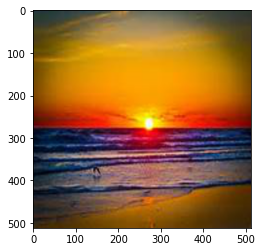

In [ ]:
plt.imshow(train_ds[0][0].permute(1, 2, 0));
print(train_ds[0][1])

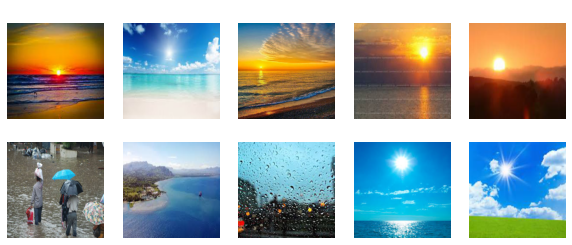

In [ ]:
fig = plt.figure(figsize=(10, 4))
for i in range(1, 10+1):
    img = train_ds[i-1][0]
    fig.add_subplot(2, 5, i)
    plt.axis("off")
    label = train_ds[i-1][1]
    plt.title(label, color = "white")
    plt.imshow(img.permute(1, 2, 0))
plt.show()

In [ ]:
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=8, shuffle=True)

In [ ]:
for images, labels in train_dl:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([8, 3, 512, 512])
torch.Size([8])


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
device

device(type='cuda')

# Create Model

In [ ]:
def create_model():
    model = nn.Sequential(
        nn.Conv2d(3, 16, 3, padding=1), #16, 512
        nn.ReLU(),
        nn.MaxPool2d(2), #16, 256
        nn.Conv2d(16, 32, 3, padding=1), # 32, 256
        nn.ReLU(),
        nn.MaxPool2d(2), #32, 128
        nn.Conv2d(32, 64, 3, padding=1), #64, 128
        nn.ReLU(),
        nn.MaxPool2d(2), #64, 64
        nn.Conv2d(64, 32, 3, padding=1), #32, 64
        nn.ReLU(),
        nn.MaxPool2d(2), #32, 32
        nn.Conv2d(32, 64, 3, padding=1), #64, 32
        nn.ReLU(),
        nn.MaxPool2d(2), #64, 16
        nn.Conv2d(64, 128, 3, padding=1), #128, 16
        nn.ReLU(),
        nn.AdaptiveAvgPool2d(1), # 128

        nn.Flatten(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 4)

    )
    return model

# Create Functions for raining

In [ ]:
def compute_accuracy(model, dl, device="cpu"):
    correct = 0
    total = 0
    for images, labels in dl:
        images = images.to(device)
        labels = labels.to(device)
        value, pred = torch.max(model(images), 1)
        correct += torch.sum(pred == labels)
        total += len(labels)
    
    return correct * 100. / total

In [ ]:
def train(model, train_dl, val_dl, numb_epochs=5, lr=1e-3, device="cpu"):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    max_accuracy = -1

    val_accuracies = []
    train_accuracies = []

    for epoch in range(1, numb_epochs+1):
        losses = []
        total = 0
        for images, labels in train_dl:
            images = images.to(device)
            labels = labels.long().to(device)
            pred = model(images)
            optimizer.zero_grad()
            loss = loss_fn(pred, labels)
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item() * len(labels))
            total += len(labels)

        train_loss = sum(losses)/total
        val_accuracy = compute_accuracy(model, val_dl, device=device)
        train_accuracy = compute_accuracy(model, train_dl, device=device)

        val_accuracies.append(val_accuracy)
        train_accuracies.append(train_accuracy)

        if val_accuracy > max_accuracy:
            max_accuracy = val_accuracy
            best_model = copy.deepcopy(model)
            print("Better Model")

        print(f"Epoch: {epoch} Loss: {train_loss} Train Accuracy {train_accuracy} % Validation Accuracy {val_accuracy} %")

    plt.plot(val_accuracies, label="Validation Accuracies")
    plt.plot(train_accuracies, label="Training Accuracies")
    plt.legend()
    plt.show()
    return best_model

In [ ]:
model = create_model()

Epoch: 1 Loss: 1.0412969825759766 Train Accuracy 40.77381134033203 % Validation Accuracy 50.000003814697266 %
Epoch: 2 Loss: 0.8810279118636298 Train Accuracy 51.88492202758789 % Validation Accuracy 58.92857360839844 %
Epoch: 3 Loss: 0.8388944987266783 Train Accuracy 66.76587677001953 % Validation Accuracy 70.53572082519531 %
Epoch: 4 Loss: 0.7555377544864775 Train Accuracy 73.41270446777344 % Validation Accuracy 77.67857360839844 %
Epoch: 5 Loss: 0.6634317625846181 Train Accuracy 73.90873718261719 % Validation Accuracy 75.0 %
Epoch: 6 Loss: 0.6104931151346554 Train Accuracy 69.34524536132812 % Validation Accuracy 62.500003814697266 %
Epoch: 7 Loss: 0.5953598146637281 Train Accuracy 74.50397491455078 % Validation Accuracy 75.89286041259766 %
Epoch: 8 Loss: 0.5776885799945347 Train Accuracy 74.50397491455078 % Validation Accuracy 71.42857360839844 %
Epoch: 9 Loss: 0.5926026221778657 Train Accuracy 75.3968276977539 % Validation Accuracy 80.35714721679688 %
Epoch: 10 Loss: 0.5575648773284

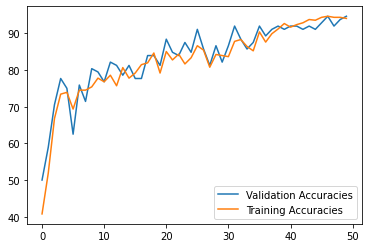

In [ ]:
best_model = train(model, train_dl, val_dl, numb_epochs=50, lr=1e-3, device=device)

Better Model
Epoch: 1 Loss: 0.13155984825321607 Train Accuracy 97.22222900390625 % Validation Accuracy 96.42857360839844 %
Better Model
Epoch: 2 Loss: 0.08987606795770782 Train Accuracy 97.81746673583984 % Validation Accuracy 98.21428680419922 %
Epoch: 3 Loss: 0.10486745237121506 Train Accuracy 97.71826171875 % Validation Accuracy 98.21428680419922 %
Epoch: 4 Loss: 0.10252255118555492 Train Accuracy 96.42857360839844 % Validation Accuracy 96.42857360839844 %
Better Model
Epoch: 5 Loss: 0.12363231229403662 Train Accuracy 96.82540130615234 % Validation Accuracy 99.10714721679688 %
Epoch: 6 Loss: 0.12072311755683687 Train Accuracy 96.62699127197266 % Validation Accuracy 97.3214340209961 %
Epoch: 7 Loss: 0.10075294965552906 Train Accuracy 98.51190948486328 % Validation Accuracy 99.10714721679688 %
Epoch: 8 Loss: 0.07314055052305025 Train Accuracy 98.41270446777344 % Validation Accuracy 99.10714721679688 %
Epoch: 9 Loss: 0.060923229843851116 Train Accuracy 98.3134994506836 % Validation Accu

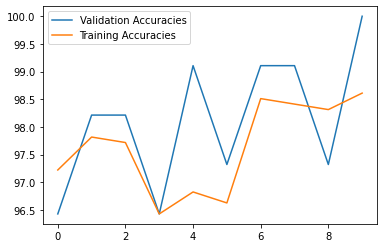

In [ ]:
best_model = train(best_model, train_dl, val_dl, 10, 1e-3, device=device)

In [ ]:
compute_accuracy(best_model.to(device), val_dl, device=device)

tensor(100.0000, device='cuda:0')

In [ ]:
for images, labels in val_dl:
    images = images.to(device)
    value, pred = torch.max(best_model(images), 1)
    print(pred)
    print(labels)
    print()
    # break

tensor([0, 1, 2, 2, 2, 0, 0, 2], device='cuda:0')
tensor([0, 1, 2, 2, 2, 0, 0, 2])

tensor([3, 0, 3, 3, 0, 1, 3, 1], device='cuda:0')
tensor([3, 0, 3, 3, 0, 1, 3, 1])

tensor([3, 2, 3, 0, 2, 2, 1, 1], device='cuda:0')
tensor([3, 2, 3, 0, 2, 2, 1, 1])

tensor([2, 2, 0, 2, 2, 2, 2, 1], device='cuda:0')
tensor([2, 2, 0, 2, 2, 2, 2, 1])

tensor([1, 3, 2, 3, 2, 0, 3, 3], device='cuda:0')
tensor([1, 3, 2, 3, 2, 0, 3, 3])

tensor([2, 1, 2, 2, 3, 3, 3, 3], device='cuda:0')
tensor([2, 1, 2, 2, 3, 3, 3, 3])

tensor([3, 3, 0, 2, 3, 1, 2, 2], device='cuda:0')
tensor([3, 3, 0, 2, 3, 1, 2, 2])

tensor([3, 1, 3, 0, 0, 2, 2, 3], device='cuda:0')
tensor([3, 1, 3, 0, 0, 2, 2, 3])

tensor([2, 3, 2, 1, 2, 0, 2, 2], device='cuda:0')
tensor([2, 3, 2, 1, 2, 0, 2, 2])

tensor([0, 3, 0, 0, 2, 3, 0, 0], device='cuda:0')
tensor([0, 3, 0, 0, 2, 3, 0, 0])

tensor([3, 0, 0, 2, 1, 0, 0, 3], device='cuda:0')
tensor([3, 0, 0, 2, 1, 0, 0, 3])

tensor([1, 2, 3, 1, 1, 0, 2, 3], device='cuda:0')
tensor([1, 2, 3, 1, 1, 0, 

In [ ]:
torch.save(best_model.state_dict(), "best_model.pth")

In [ ]:
decoder = {
    0: "cloudy",
    1: "rainy",
    2: "shine",
    3: "sunrise"
}

In [ ]:
url = "https://ichef.bbci.co.uk/images/ic/720x405/p07fwg7x.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

In [ ]:
img = transform(img)

In [ ]:
img = img.unsqueeze(0).to(device)

In [ ]:
img.shape

torch.Size([1, 3, 512, 512])

In [ ]:
with torch.no_grad():
    pred = best_model(img)
print(decoder[np.argmax(nn.functional.softmax(pred, dim=-1).cpu().numpy())])

rainy


In [ ]:
def infer(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    plot_img = np.array(img)
    plt.imshow(plot_img)
    img = transform(img)
    img = img.unsqueeze(0).to(device)
    with torch.no_grad():
        pred = best_model(img)
    return nn.functional.softmax(pred, dim=-1).cpu().numpy()

Predicted cloudy with probability 97.75776863098145 %
[[0.9775777  0.00255989 0.01467397 0.00518832]]


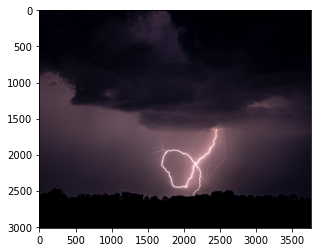

In [ ]:
url = "https://www.gannett-cdn.com/presto/2019/06/03/PMJS/f4a2427e-2c69-4476-b089-23662fd09209-lightning_photo.jpg"
pred = infer(url)
pred_idx = np.argmax(pred)
print(f"Predicted {decoder[pred_idx]} with probability {pred[0][pred_idx] * 100} %")
print(pred)